<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/computer_vision_tf2_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoteBook 1 : CNN 기초 연산 살펴보기

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/computer_vision_tf2/dl-vision/Chapter03

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/computer_vision_tf2/dl-vision/Chapter03


In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from skimage import io

## Setup

In [ ]:
image = io.imread("./res/bird_pic_by_benjamin_planche.png")   # 예시 이미지를 하나 불러온다.

Image shape: (680, 608)


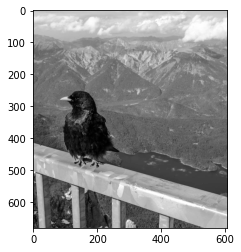

In [ ]:
print("Image shape: {}".format(image.shape))
plt.imshow(image, cmap=plt.cm.gray)

우리는 이 이미지를 TensorFlow operations에 넣기 위해, Tensor로 변환할 것이다:

In [ ]:
image = tf.convert_to_tensor(image, tf.float32, name="input_image")

Tensorflow의 기본적인 연산들은 대부분 배치 묶음의 차원을 갖고 있기 때문에 다음과 같이 변환 시킬 것이다.

In [ ]:
image.shape  # 현재 사진의 벡터

TensorShape([680, 608])

In [ ]:
image = tf.expand_dims(image, axis=0)  # 텐서의 0차원을 확장한다.
image.shape

TensorShape([1, 680, 608])

비슷하게, 우리는 현재 gray-scale의 데이터를 갖고 있기 때문에 RGB가 아니다. 따라서 한 차원 더 확장시켜준다.

In [ ]:
image = tf.expand_dims(image, axis=-1) # we expand our tensor, adding a dimension at position 0
print("Tensor shape: {}".format(image.shape))

Tensor shape: (1, 680, 608, 1)


## Convolution

2장에서 본 것과 같이**image convolution**을 수행하는 함수는 `tf.nn.conv2()`이다.  
우리는 이번 챕터에서의 그림3과 4를 만들때도 사용할 것이다.

그림 3에서, 우리는 주로 Blur이미지(Gaussian blur)에 사용되는 3*3 filter (or kernel)를 정의할 것이다.

In [ ]:
kernel = tf.constant([[1 / 16, 2 / 16, 1 / 16],
                      [2 / 16, 4 / 16, 2 / 16],
                      [1 / 16, 2 / 16, 1 / 16]], tf.float32, name="gaussian_kernel")

그러나 컨볼루션 계층은 filter의 tensor가 ***(k, k, D, N)*** 모양이어야 한다. 우리의 경우 ***D=1*** and ***N=1***이지만, 우리는 이러한 값들을 명시적으로 표현하기 위해 커널을 재구성할 필요가 있다:

In [ ]:
print(kernel.shape)
kernel

(3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.0625, 0.125 , 0.0625],
       [0.125 , 0.25  , 0.125 ],
       [0.0625, 0.125 , 0.0625]], dtype=float32)>

In [ ]:
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)  # 차원 확장

In [ ]:
kernel.shape

TensorShape([3, 3, 1, 1])

커널로 이미지를 필터링하려면 이제 `tf.nn.conv2()`를 호출하기만 하면 된다.

In [ ]:
blurred_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding="SAME")

기본적으로 TensorFlow 2에서 사용하는 *eager execution*는 작업 결과를 즉시 계산하여 덮어쓴다.

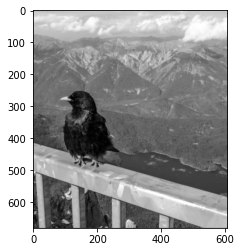

In [ ]:
blurred_res = blurred_image.numpy()
# 첫번째 이미지를 택해, 차원을 되돌려준다.
blurred_res = blurred_res[0, ..., 0]

plt.imshow(blurred_res, cmap=plt.cm.gray)

새의 깃털 부분을 보면 Blur가 잘 된 것을 확인할 수 있다.

그림 4에선 ***contour detection***(윤곽선 검출)을 할 것이다. 이 kernel은 다음과 같이 정의할 수 있다.

In [ ]:
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], tf.float32, name="edge_kernel")  # 윤곽선을 검출할 kernel
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)  # 차원을 확장해준다.

이번에는 더 큰 stride를 사용하여 이것이 결과 텐서에 어떤 영향을 미치는지 보자.

(340, 304)


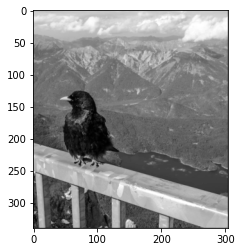

In [ ]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="SAME")
edge_res = edge_image.numpy()[0, ..., 0]   # 차원을 원래대로 돌려주기
plt.imshow(edge_res, cmap=plt.cm.gray)
print(edge_res.shape)

자세히 보면, 이미지의 테두리가 흰색이다. 이는 커널에 의해 윤곽선으로 감지된 제로 패딩(패딩 "SAME"을 선택했기 때문에)에 의해 발생한다. 실제로 이미지를 패드하지 않으면 사라진다.

(339, 303)


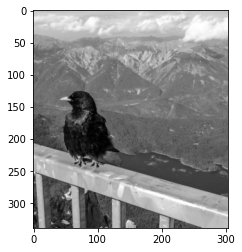

In [ ]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="VALID")
edge_res = edge_image.numpy()[0, ..., 0]   # 차원을 원래대로 돌려주기
plt.imshow(edge_res, cmap=plt.cm.gray)
print(edge_res.shape)  # 개수가 하나씩 빠져 있음을 볼 수 있다.

padding 옵션을 SAME으로 설정하면 시작과 같은 사이즈의 결과가 출력이 되고, VALID로 설정하면 내부에 있는 데이터만 사용하기 때문에 데이터 유실의 문제가 생길 수 있다.

## Pooling

For ***max-pooling*** and ***average-pooling***, 이들은 각각 창의 최댓, 평균 연산을 적용한다.

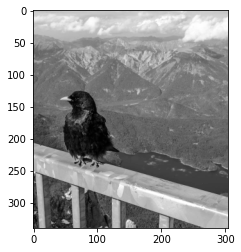

In [ ]:
avg_pooled_image = tf.nn.avg_pool(image, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
avg_res = avg_pooled_image.numpy()[0, ..., 0]
plt.imshow(avg_res, cmap=plt.cm.gray)

이러한 하이퍼 파라미터로, 평균 풀링은 ksize를 [1, 2, 2, 1]로 설정하여, 옆의 원소와의 평균을 계산한다.

이제는 max-pooling을 해보자. 

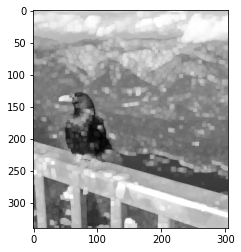

In [ ]:
max_pooled_image = tf.nn.max_pool(image, ksize=[1, 10, 10, 1], strides=[1, 2, 2, 1], padding="SAME")
max_res = max_pooled_image.numpy()[0, ..., 0]
plt.imshow(max_res, cmap=plt.cm.gray)

ksize를 매우 큰 10으로 설정하여, 어떻게 작동하는지 알아봤다.

## Conclusion

앞에서 제시한 fully-connected layer에 이러한 작업을 추가하면,  
 이제 다음 노트의 주제가 될 첫 번째 CNN을 구축할 수 있는 도구가 갖춰졌다.

# NoteBook 2 : 텐서플로2와 케라스로 CNN 만들고 학습시키기

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


## Preparing the Data

In [4]:
num_classes = 10  # 0부터 9까지의 숫자
img_rows, img_cols, img_ch = 28, 28, 1   # 이미지의 크기 벡터
input_shape = (img_rows, img_cols, img_ch)

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # 0부터 1까지로 변환

x_train = x_train.reshape(x_train.shape[0], *input_shape)  # *을 붙이면 tuple로 압축.
x_test = x_test.reshape(x_test.shape[0], *input_shape)

## Buliding and Training LeNet-5

keras를 이용해 CNN을 구성해보자.

### Instantating Convolutional Layers

이전 노트에서 컨볼루션을 수행하였지만, NN에서는 필터를 **훈련**시켜야 하며, **bais**와 **activation function**을 추가해야한다.  
그러므로 우리는 1장에서 fully-connected layer에서 했던것 처럼 Convolution Operation을 `Layer`안으로 넣어야한다.  
Tensorflow2/Keras는 확장할 수 있는 `tf.keras.Layer` 클래스를 제공한다.  
 이러한 Convolution Layer을 어떻게 세분화하는지 다음에서 볼 수 있다:

In [ ]:
class SimpleConvolutionLayer(tf.keras.layers.Layer):
    
    def __init__(self, num_kernels=32, kernel_size=(3, 3), strides=(1, 1), use_bias=True):
        """
        Initialize the layer.
        :param num_kernels:    Number of kernels for the convolution
        :param kernel_size:    Kernel size (H x W)
        :param strides:        Vertical and horizontal stride as list
        :param use_bias:       Flag th add a bias after convolution / before activation
        """
        # First, we have to call the 'Layer' super __init__(), as it initializes hidden mechanisms:
        super().__init__()
        # Then we assign the parameters:
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias

    def bulid(self, input_shape):
        """
        Build the layer, initializing its parameters according to the input shape.
        This function will be internally called the first time the layer is used, though
        it can also be manually called.
        :param input_shape:     Input shape the layer will receive (e.g. B x H x W x C)
        """
        # We are provided with the input shape here, so we know the number of input channels:
        num_input_channels = input_shape[-1]  # assuming shape format BHWC
